# Background Dynamics
The first section of this notebook is dedicated to the background dynamics of inflation, which are governed by the following equations:

$$ H^2 \equiv \frac{1}{3m_p^2} \, \rho_{\phi} = \frac{1}{3m_p^2} \left[\frac{1}{2}{\dot\phi}^2 +V(\phi)\right], $$
$$ \dot{H} \equiv \frac{\ddot{a}}{a}-H^2 = -\frac{1}{2m_p^2}\, \dot{\phi}^2, $$
$$ {\ddot \phi}+ 3\, H {\dot \phi} + V_{,\phi}(\phi) = 0. $$

## Prerequisites
Before proceeding, ensure that all the required packages are installed and imported (as they are needed for the mathematical operations, and for formatting and plotting results):

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import brentq
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as pch
from matplotlib import rcParams
from matplotlib import rc
from matplotlib.ticker import AutoMinorLocator

In [2]:
mpl.rcParams.update({
    "axes.formatter.use_mathtext": True,
    "axes.formatter.limits": (-3, 3),
    "axes.formatter.min_exponent": -3,
})

## Defining the model (T-model $\alpha$-attractor)
We begin by defining the model of inflation (as considered by the reader). This involves defining the potential of the inflaton $V(\phi)$, its derivatives and any other required constants/quantities. For example, we can consider the case of the inflaton with a Starobinsky potential. 

$$ V(\phi)=V_0\tanh^{2n}\left(\lambda \frac{\phi}{m_p}\right) $$

Note that we have converted all the physical quantities to its dimensionless equivalents (see [arxiv:2212.00529](https://arxiv.org/abs/2212.00529) for details). Briefly, we describe the conversions below:

$$ T = \left( t \, m_p \right) \, S~, \quad  x = \frac{\phi}{m_p}~, \quad y =  \left( \frac{\dot{\phi}}{m_p^{2}} \right) \, \frac{1}{S}~,$$
$$ z = \left( \frac{H}{ m_p} \right) \, \frac{1}{S}~, \quad A = \left( a \, m_p \right) \, S,$$

where $S$ is a factor used to re-scale the time-variable to ease the numerical computation. The factor may be suitably chosen according to the energy scale of the dynamics.

In [3]:
# This term defines one unit of time [ T = t * m_p * S ] where t is the actual cosmic time
S = 5e-5

# dimensionless potential function and its derivatives
n = 1
p = 2*n
lamda = 1e-4

def tanh_term(x):
    global lamda
    return np.tanh(lamda*x)

def f(x):
    global lamda, p
    return tanh_term(x)**p

def dfdx(x):
    global lamda, p
    return p*lamda*(1-tanh_term(x)**2)*tanh_term(x)**(p-1)

def d2fdx2(x):
    global lamda, p
    return p*(lamda**2)*(1-tanh_term(x)**2)*tanh_term(x)**(p-2)*(p-1-(p+1)*tanh_term(x)**2)

## Calculating $x_i$ & $V_0$

In [4]:
Nt = 77.4859 # number of e-folds elapsed when inflation ends
x_end = np.arcsinh(np.sqrt(2)*p*lamda)/(2*lamda)
print("x_end:", x_end)

x_end: 1.4142135435169148


In [5]:
def N(x):
    global lamda, x_end
    def integrand(x):
        return (np.sinh(lamda*x))**2/(2*p*lamda**2)
    return integrand(x)-integrand(x_end)

def solve(x, f, fval):
    global lamda
    return f(x)-fval

In [6]:
xi = brentq(lambda x: solve(x, N, Nt), 0, 30, xtol=1e-15, rtol=1e-15, maxiter=100)
print("xi:", xi)

xi: 17.661915966220686


### Adjust the value of $V_0$ in the code such that $P_s$ at $N_e=60$ should be approximately $2.1\times10^{-9}$.

In [7]:
Nk = 60
P_star = 2.1e-9
k_star = 0.05

In [8]:
x_star = brentq(lambda x: solve(x, N, Nk), 0, 30, xtol=1e-15, rtol=1e-15, maxiter=100)
print("x_star:", x_star)

x_star: 15.556342910431058


In [9]:
def calc_V0(x_star, P_star):
    return P_star*(12*np.pi**2)*(dfdx(x_star)**2)/f(x_star)**3

In [10]:
V0 = calc_V0(x_star, P_star)
print("V0:", V0)
print("m:", np.sqrt(2)*V0*lamda)

V0: 0.0016987502970403077
m: 2.402395709159727e-07


## Defining the system
In terms of these dimensionaless variables, the dynamical equations take the form:

$$ \frac{{\rm d}x}{{\rm d}T} = y ,$$
$$ \frac{{\rm d}y}{{\rm d}T} = -3 \, z \, y - \frac{v_0}{S^{2}} \,  f_{,x}(x),$$
$$ \frac{{\rm d}z}{{\rm d}T} = - \frac{1}{2} \, y^2 ,$$
$$ \frac{{\rm d}A}{{\rm d}T} = A \, z .$$

To solve this system as an initial value problem, we provide initial conditions to our dimensionless quantities. It should be noted that the dynamics are, in general, highly sensitive to initial conditions (please refer to [arxiv:2212.00529](https://arxiv.org/abs/2212.00529) for details).

In [11]:
yi = 0
zi = np.sqrt(yi**2/6 + (V0*f(xi)/(3*S**2)))
Ai = 1e-3  # taking a random value

We then define our system of equations and solve them using the *odeint* function from the [SciPy](https://docs.scipy.org/doc/scipy/) library.

In [12]:
def sys(var, T):
    [x, y, z, A] = var
    dxdT = y
    dydT = -3*z*y - V0*dfdx(x)/S**2
    dzdT = -0.5*y**2
    dAdT = A*z
    return [dxdT, dydT, dzdT, dAdT]

# the period of time over which the system is integrated
T = np.linspace(0, 1000, 100000)

sol = odeint(sys, [xi,yi,zi,Ai], T, rtol=3e-14, atol=2e-35, mxstep=900000000)
x, y, z, A = np.transpose(sol)
phi, phi_t, H = x, y*S, z*S #converting back to dimensional quantities

## Defining useful parameters
Finally, after solving the system of equations, we can define derived quantities which are important to the system being considered. These are:

- The number of e-folds before the end of inflation: $N_e  = \log_e{\dfrac{a_{\rm end}}{a(t)}}=\int_{t}^{t_{\rm end}} H(t') dt'$
- The slow-roll parameters: $\epsilon_H = -\dfrac{\dot{H}}{H^2}=\dfrac{1}{2m_p^2}\dfrac{\dot{\phi}^2}{H^2}~,~~\eta_H = -\dfrac{\ddot{\phi}}{H\dot{\phi}}=\epsilon_H  - \dfrac{1}{2\epsilon_H} \, \dfrac{d\epsilon_H}{dN_e}$
- The power spectra of scalar and tensor fluctuations: $P_{\zeta} = \dfrac{1}{8\pi^2}\left(\dfrac{H}{m_p}\right)^2\dfrac{1}{\epsilon_H}~,~~P_T(k)  = \dfrac{2}{\pi^2} \left( \dfrac{H}{m_p} \right)^2$
- The scalar spectral tilt: $n_s = 1 + 2\eta_H - 4\epsilon_H~$ and the tensor-to-scalar ratio: $r = 16\epsilon_H$

We write these in terms of our dimensionless quantities as (in code):

In [13]:
N = np.log(A/Ai) # number of e-folds of expansion elapsed
Ne = Nt - N

epsH = -(-z**2 + ((V0*f(x)/S**2 - y**2))/3)/z**2 # indicates whether the system is in a state of inflation
etaH = -(-3*z*y - V0*dfdx(x)/S**2)/(y*z) # gives the rate of change of epsH

ns = 1 + 2*etaH - 4*epsH #
nT = -2*epsH
r = 16*epsH
Ps = (S*z)**2 / (8 * np.pi**2 * epsH)
Pt = 2*(S*z)**2 / (np.pi**2)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_28644\3872460911.py:5: RuntimeWarning: divide by zero encountered in true_divide
  etaH = -(-3*z*y - V0*dfdx(x)/S**2)/(y*z) # gives the rate of change of epsH
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_28644\3872460911.py:10: RuntimeWarning: divide by zero encountered in true_divide
  Ps = (S*z)**2 / (8 * np.pi**2 * epsH)


## Plotting results
Having done the necessary calculations, we can plot the evolution of various quantities (including those mentioned earlier) and analyse their behaviour. To ensure that the output observed is valid, we constrian certain aspects of the background dynamics with observational data. They are as follows:

In [14]:
def i(f, val):
    return np.max(np.where(f<=val))

In [15]:
def sci_notation(val, decimals=2):
    """Convert a float to scientific notation string with ×10ⁿ formatting."""
    s = f"{val:.{decimals}e}"
    base, exp = s.split("e")
    exp = int(exp)
    return rf"{base}×10^{{{exp}}}"

### 1. Check if inflation is occuring:
When the universe inflates, the number of e-folds ($N$) should increase rapidly with time; whose growth slows down substantially after the end of inflation.

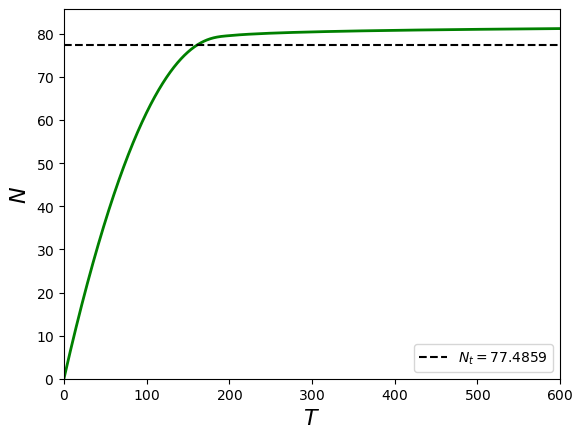

In [16]:
plt.plot(T, N,'g', lw=2)
plt.xlabel(f'$T$', fontsize=16)
plt.xlim(0, 600)
plt.ylabel(f'$N$', fontsize=16)
plt.ylim(bottom = 0)
plt.axhline(Nt, color='black', linestyle='--', label = f'$N_t={Nt}$')
plt.legend()
plt.savefig("./Figures/efolds vs time.pdf", dpi=300, bbox_inches='tight')
plt.show()

We can observe from the plot that the universe was inflating till about T=750.

### 2. Check if inflation is adequate:

The universe experiences inflation when $\epsilon_H < 1$. As a result, the point at which its value passes 1 for the first time marks the end of inflation. The number of e-folds achieved during inflation can be obtained from here.

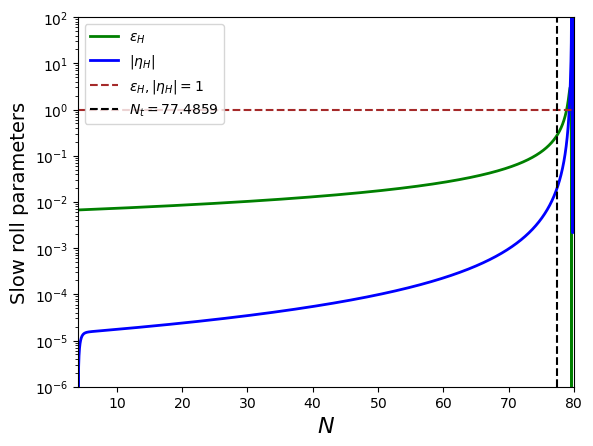

In [17]:
plt.plot(N, epsH, 'g', lw=2, label=r'$\epsilon_H$')
plt.plot(N, abs(etaH), 'b', lw=2, label=r'$|\eta_H|$')
plt.yscale('log')
plt.axhline(1, color='brown', linestyle='--', label = f'$\epsilon_H,|\eta_H|=1$')
plt.axvline(Nt, color='black', linestyle='--', label = f'$N_t={Nt}$')
plt.xlabel(r'$N$', fontsize=16)
plt.xlim(4,80)
plt.ylim(1e-6,1e2)
plt.ylabel(r'Slow roll parameters', fontsize=14)
plt.legend()
plt.savefig("./Figures/eta-eps vs N.pdf", dpi=300, bbox_inches='tight')
plt.show()

Here, the universe undergoes about 77 e-folds of accelerated expansion.

### 3. Check Inflation trajectory

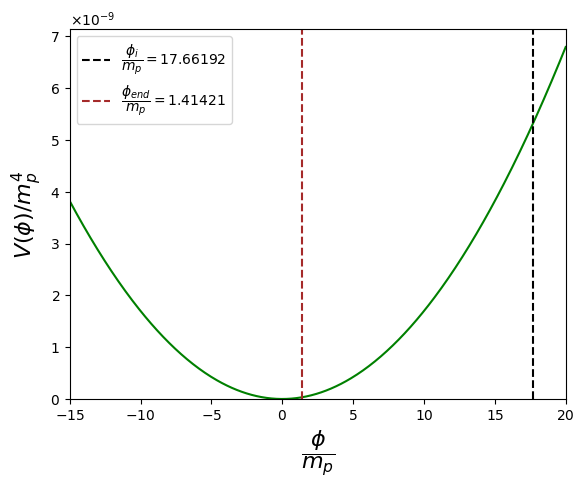

In [18]:
Phi = np.linspace(-15,20,500)
plt.plot(Phi, V0*f(Phi), 'g')
plt.xlim(min(Phi), max(Phi))
plt.ylim(bottom = 0)
plt.axvline(xi, color='black', linestyle='--', label = f'$\\dfrac{{\phi_i}}{{m_p}}={xi:.5f}$')
plt.axvline(x_end, color='brown', linestyle='--', label = f'$\\dfrac{{\phi_{{end}}}}{{m_p}}={x_end:.5f}$')
plt.xlabel(r'$\dfrac{\phi}{m_p}$', fontsize=16)
plt.ylabel(r'$V(\phi)/m_p^4$', fontsize=16)
plt.legend()
plt.savefig("./Figures/V vs field.pdf", dpi=300, bbox_inches='tight')
plt.show()

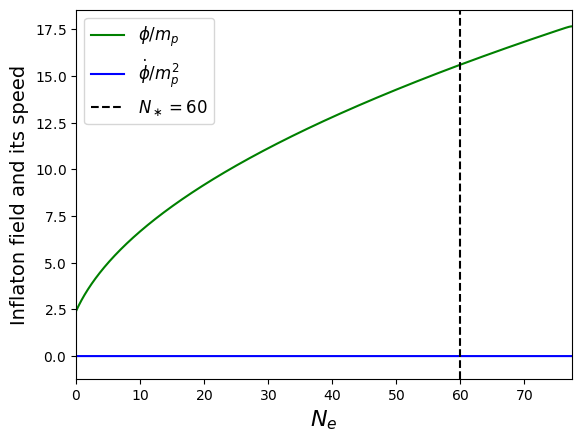

In [19]:
plt.plot(Ne, phi, 'g', label=r'$\phi/m_p$')
plt.plot(Ne, phi_t, 'b', label=r'$\dot{\phi}/m_p^2$')
plt.axvline(Nk, color='black', linestyle='--', label = fr'$N_\ast={Nk}$')
plt.xlabel(r'$N_e$', fontsize=16)
plt.xlim(0, max(Ne))
plt.ylabel(r'Inflaton field and its speed', fontsize=14)
plt.legend(fontsize=12)
plt.savefig("./Figures/Phi and dot vs Ne.pdf", dpi=300, bbox_inches='tight')
plt.show()

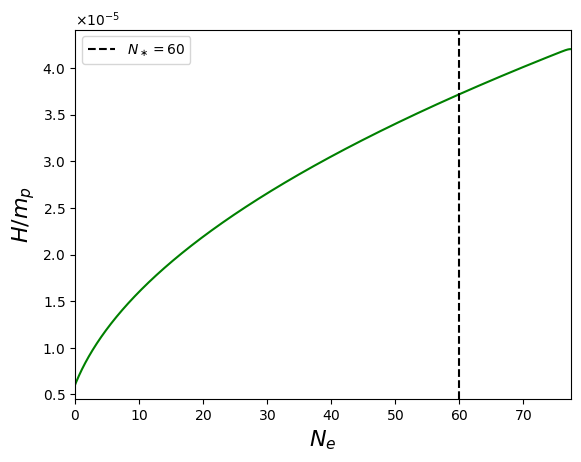

In [20]:
plt.plot(Ne, H, 'g')
plt.axvline(Nk, color='black', linestyle='--', label = fr'$N_\ast={Nk}$')
plt.xlabel(r'$N_e$', fontsize=16)
plt.ylabel(r'$H/m_p}$', fontsize=16)
plt.xlim(0, max(Ne))
plt.ylim(bottom=4.5e-6)
plt.legend()
plt.savefig("./Figures/H vs Ne.pdf", dpi=300, bbox_inches='tight')
plt.show()

### 4. Matching the amplitude of power spectrum

We need to ensure that the value of the power spectrum around the CMB pivot scale, as obtained from our computation, matches with the observed value from the latest CMB data [(PLANCK 2018)](https://arxiv.org/abs/1807.06211).

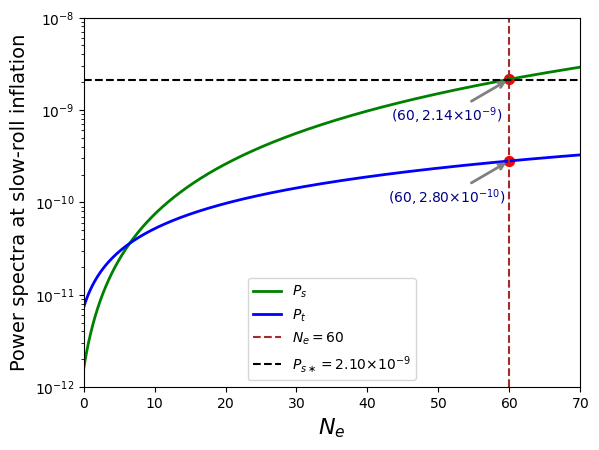

In [21]:
plt.plot(Ne, Ps, 'g', lw=2, label=r'$P_s$')
plt.plot(Ne, Pt, 'b', lw=2, label=r'$P_t$')
plt.axvline(Nk, color='brown', linestyle='--', label = f'$N_e={Nk}$')
plt.axhline(P_star, color='black', linestyle='--', label = fr'$P_{{s\ast}}={sci_notation(P_star)}$')
px=Nk 
py=Ps[i(N, Nt-Nk)]
plt.annotate(fr'$({px}, {sci_notation(py)})$', 
             (px, py), 
             textcoords="offset points", 
             xytext=(-45, -30),   # offset from point
             ha='center', 
             fontsize=10, 
             color='darkblue',
             arrowprops=dict(arrowstyle='->', color='gray', lw=2))
plt.scatter(px, py, color='r', s=50)

px=Nk 
py=Pt[i(N, Nt-Nk)]
plt.annotate(fr'$({px}, {sci_notation(py)})$', 
             (px, py), 
             textcoords="offset points", 
             xytext=(-45, -30),   # offset from point
             ha='center', 
             fontsize=10, 
             color='darkblue',
             arrowprops=dict(arrowstyle='->', color='gray', lw=2))
plt.scatter(px, py, color='r', s=50)

plt.yscale('log')
plt.xlim(0,70)
plt.ylim(1e-12,1e-8)
plt.xlabel(r'$N_e$', fontsize=16)
plt.ylabel(r'Power spectra at slow-roll inflation', fontsize=14)
plt.legend()
plt.savefig("./Figures/Ps-Pt vs Ne.pdf", dpi=300, bbox_inches='tight')
plt.show()

### 5. Check the path taken by the model

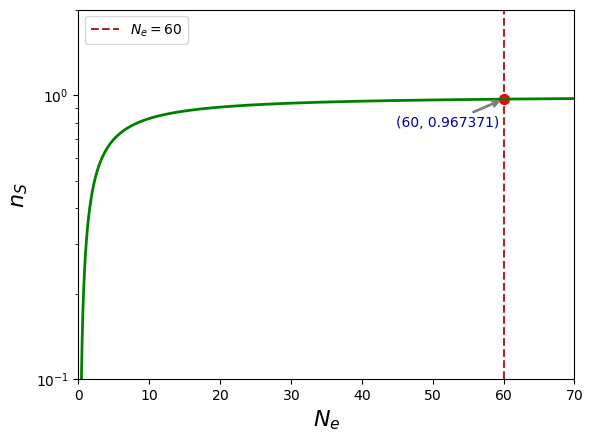

In [22]:
plt.plot(Ne, ns, 'g', lw=2)
plt.axvline(Nk, color='brown', linestyle='--', label = f'$N_e={Nk}$')
px=Nk 
py=ns[i(N, Nt-Nk)]
plt.annotate(f'({px}, {py:.6f})', 
             (px, py), 
             textcoords="offset points", 
             xytext=(-40, -20),   # offset from point
             ha='center', 
             fontsize=10, 
             color='darkblue',
             arrowprops=dict(arrowstyle='->', color='gray', lw=2))
plt.scatter(px, py, color='r', s=50)
plt.yscale('log')
plt.xlim(0,70)
plt.ylim(1e-1,2)
plt.xlabel(r'$N_e$', fontsize=16)
plt.ylabel(r'$n_S$', fontsize=16)
plt.legend()
plt.savefig("./Figures/nS vs Ne.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [23]:
print(ns[i(N, Nt-Nk)])

0.9673709010946757


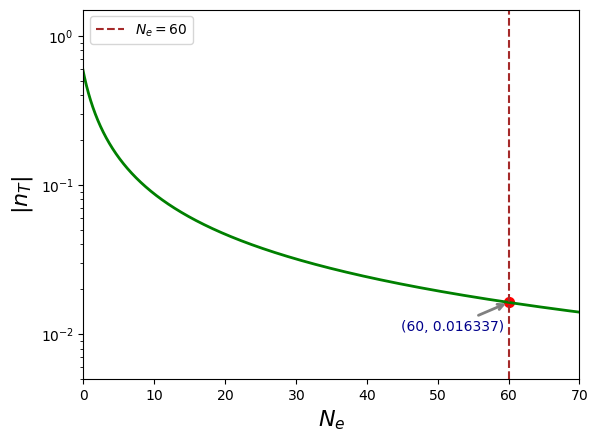

In [51]:
plt.plot(Ne, abs(nT), 'g', lw=2)
plt.axvline(Nk, color='brown', linestyle='--', label = f'$N_e={Nk}$')
px=Nk 
py=abs(nT[i(N, Nt-Nk)])
plt.annotate(f'({px}, {py:.6f})', 
             (px, py), 
             textcoords="offset points", 
             xytext=(-40, -20),   # offset from point
             ha='center', 
             fontsize=10, 
             color='darkblue',
             arrowprops=dict(arrowstyle='->', color='gray', lw=2))
plt.scatter(px, py, color='r', s=50)
plt.yscale('log')
plt.xlim(0,70)
plt.ylim(5e-3,1.5)
plt.xlabel(r'$N_e$', fontsize=16)
plt.ylabel(r'$|n_T|$', fontsize=16)
plt.legend()
plt.savefig("./Figures/nT vs Ne.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [24]:
ns_50 = ns[i(N, Nt-50)]
print("index of Ne=50:", i(N, Nt-50))
print("ns_50:", ns_50)

index of Ne=50: 3608
ns_50: 0.9610296330216559


In [25]:
ns_60 = ns[i(N, Nt-60)]
print("index of Ne=60:", i(N, Nt-60))
print("ns_60:", ns_60)

index of Ne=60: 2203
ns_60: 0.9673709010946757


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


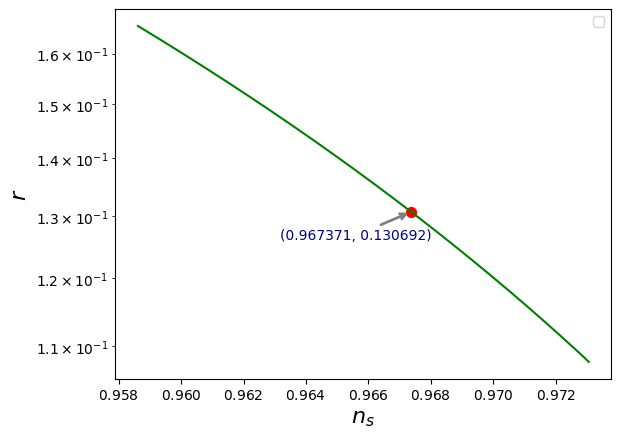

In [26]:
bound = np.arange(i(N,Nt-(Nk+13)),i(N,Nt-(Nk-13))+1,1)

plt.plot(ns[bound], r[bound], 'g')
plt.yscale('log')
px=ns[i(N, Nt-Nk)] 
py=r[i(N, Nt-Nk)]
plt.annotate(f'({px:.6f}, {py:.6f})', 
             (px, py), 
             textcoords="offset points", 
             xytext=(-40, -20),   # offset from point
             ha='center', 
             fontsize=10, 
             color='darkblue',
             arrowprops=dict(arrowstyle='->', color='gray', lw=2))
plt.scatter(px, py, color='r', s=50)
# plt.axvline(ns[i(N, Nt-Nk)], color='black', linestyle='--', label = f'$n_s(N_e={Nk})$ ={ns[i(N, Nt-Nk)]}') 
# plt.ylim(0, 1.5)
# plt.ylim(bottom = 0)
plt.xlabel(r'$n_s$', fontsize=16)
plt.ylabel(r'$r$', fontsize=16)
plt.legend()
plt.savefig("./Figures/r vs ns.pdf", dpi=300, bbox_inches='tight')
plt.show()

# Compiled function 

In [65]:
import importlib
import inflation

In [ ]:
importlib.reload(inflation)

In [66]:
def i(f, val):
    return np.max(np.where(f<=val))

In [67]:
Nt=77.4859 
Nk=60 
P_star=2.1e-9

In [68]:
def f(x, params):
    n, lamda = params
    p = 2*n
    return np.tanh(lamda*x)**p

def dfdx(x, params):
    n, lamda = params
    p = 2*n
    return p*lamda*(1-np.tanh(lamda*x)**2)*np.tanh(lamda*x)**(p-1)

def d2fdx2(x, params):
    n, lamda = params
    p = 2*n
    return p*(lamda**2)*(1-np.tanh(lamda*x)**2)*np.tanh(lamda*x)**(p-2)*(p-1-(p+1)*np.tanh(lamda*x)**2)

In [69]:
# End of inflation field value (epsilon_H ~ 1)
def calc_xend(params):
    n, lamda = params
    p = 2*n
    return np.arcsinh(np.sqrt(2)*p*lamda)/(2*lamda)

# Number of e-folds from x to x_end 
def calc_N(x, x_end, params):
    n, lamda = params
    p = 2*n
    def integrand(x):
        return (np.sinh(lamda*x))**2/(2*p*lamda**2)
    return integrand(x)-integrand(x_end)

In [70]:
model_funcs = [f, dfdx, d2fdx2]
helper_funcs = [calc_xend, calc_N]

In [71]:
phi, phi_t, H, N, Ne, eps, eta, ns, nT, r, Ps, Pt, V0 = inflation.background([1, 0.5], model_funcs, helper_funcs)

D:\Personal\Research Works\ICTP\Internship\inflation.py:102: RuntimeWarning: divide by zero encountered in true_divide
  eta = -(-3 * z * y - V0 * dfdx(x, model_params) / S**2) / (y * z)


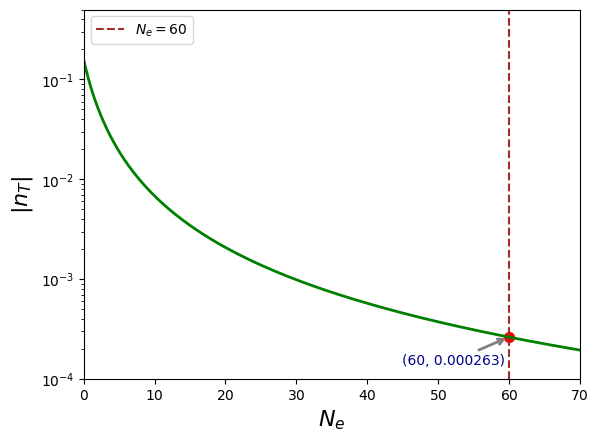

In [72]:
plt.plot(Ne, abs(nT), 'g', lw=2)
plt.axvline(Nk, color='brown', linestyle='--', label = f'$N_e={Nk}$')
px=Nk 
py=abs(nT[i(N, Nt-Nk)])
plt.annotate(f'({px}, {py:.6f})', 
             (px, py), 
             textcoords="offset points", 
             xytext=(-40, -20),   # offset from point
             ha='center', 
             fontsize=10, 
             color='darkblue',
             arrowprops=dict(arrowstyle='->', color='gray', lw=2))
plt.scatter(px, py, color='r', s=50)
plt.yscale('log')
plt.xlim(0,70)
plt.ylim(1e-4, 5e-1)
plt.xlabel(r'$N_e$', fontsize=16)
plt.ylabel(r'$|n_T|$', fontsize=16)
plt.legend()
plt.show()

### Comparison between different n valued potentials

In [73]:
phi1, phi_t1, H1, N1, Ne1, eps1, eta1, ns1, nT1, r1, Ps1, Pt1, V01 = inflation.background([1, 0.5], model_funcs, helper_funcs)
phi2, phi_t2, H2, N2, Ne2, eps2, eta2, ns2, nT2, r2, Ps2, Pt2, V02 = inflation.background([2, 0.5], model_funcs, helper_funcs)
phi3, phi_t3, H3, N3, Ne3, eps3, eta3, ns3, nT3, r3, Ps3, Pt3, V03 = inflation.background([3, 0.5], model_funcs, helper_funcs)

D:\Personal\Research Works\ICTP\Internship\inflation.py:108: RuntimeWarning: divide by zero encountered in true_divide
  Ps = (S * z) ** 2 / (8 * np.pi**2 * eps)


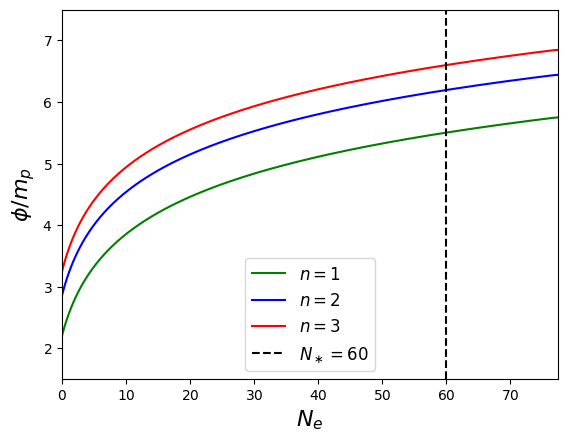

In [75]:
plt.plot(Ne1, phi1, 'g', label=r'$n=1$')
plt.plot(Ne2, phi2, 'b', label=r'$n=2$')
plt.plot(Ne2, phi3, 'r', label=r'$n=3$')
plt.axvline(Nk, color='black', linestyle='--', label = fr'$N_\ast={Nk}$')
plt.xlabel(r'$N_e$', fontsize=16)
plt.ylabel(r'$\phi/m_p$', fontsize=16)
plt.xlim(0, np.max([Ne1,Ne2,Ne3]))
plt.ylim(1.5, 7.5)
plt.legend(fontsize=12)
plt.savefig("./Figures/phi_compiled vs Ne.pdf", dpi=300, bbox_inches='tight')
plt.show()

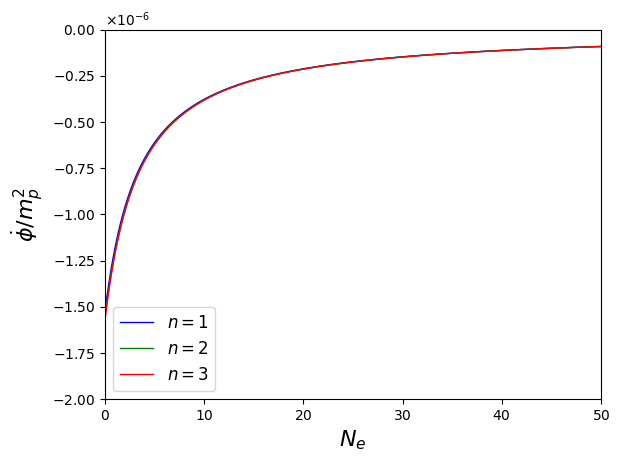

In [80]:
plt.plot(Ne1, phi_t1, 'b', lw=1, label=r'$n=1$')
plt.plot(Ne2, phi_t2, 'g', lw=1, label=r'$n=2$')
plt.plot(Ne3, phi_t3, 'r', lw=1, label=r'$n=3$')
# plt.axvline(Nk, color='black', linestyle='--', label = fr'$N_\ast={Nk}$')
plt.xlabel(r'$N_e$', fontsize=16)
plt.ylabel(r'$\dot{\phi}/m_p^2$', fontsize=16)
plt.xlim(0, 50)
plt.ylim(-2e-6, 0)
plt.legend(fontsize=12)
plt.savefig("./Figures/phidot_compiled vs Ne.pdf", dpi=300, bbox_inches='tight')
plt.show()

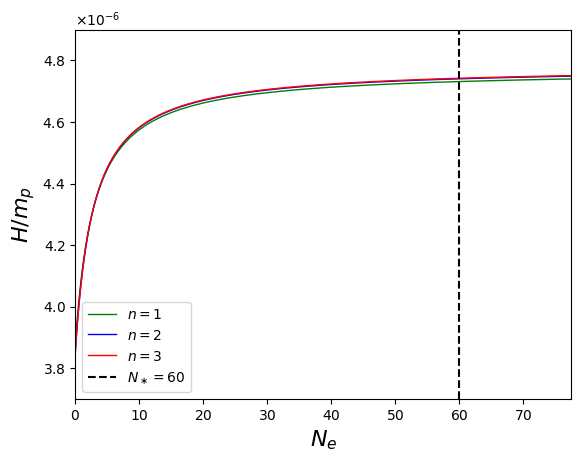

In [85]:
plt.plot(Ne1, H1, 'g', lw=1, label=r'$n=1$')
plt.plot(Ne2, H2, 'b', lw=1, label=r'$n=2$')
plt.plot(Ne3, H3, 'r', lw=1, label=r'$n=3$')
plt.axvline(Nk, color='black', linestyle='--', label = fr'$N_\ast={Nk}$')
plt.xlabel(r'$N_e$', fontsize=16)
plt.ylabel(r'$H/m_p}$', fontsize=16)
plt.xlim(0, np.max([Ne1, Ne2, Ne3]))
plt.ylim(3.7e-6, 4.9e-6)
plt.legend()
plt.savefig("./Figures/H_compiled vs Ne.pdf", dpi=300, bbox_inches='tight')
plt.show()

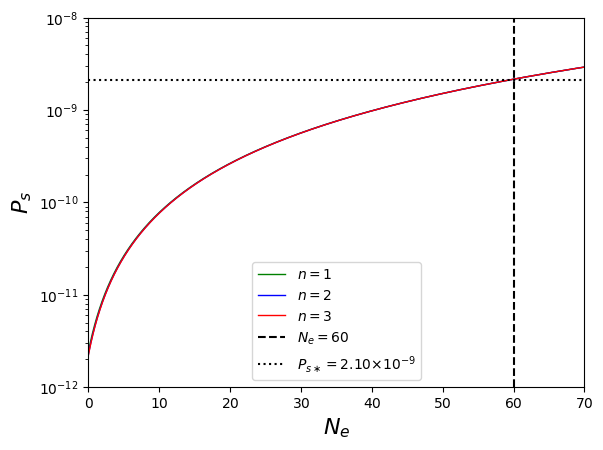

In [86]:
plt.plot(Ne1, Ps1, 'g', lw=1, label=r'$n=1$')
plt.plot(Ne2, Ps2, 'b', lw=1, label=r'$n=2$')
plt.plot(Ne3, Ps3, 'r', lw=1, label=r'$n=3$')
plt.axvline(Nk, color='black', linestyle='--', label = f'$N_e={Nk}$')
plt.axhline(P_star, color='black', linestyle=':', label = fr'$P_{{s\ast}}={sci_notation(P_star)}$')
plt.yscale('log')
plt.xlim(0,70)
plt.ylim(1e-12,1e-8)
plt.xlabel(r'$N_e$', fontsize=16)
plt.ylabel(r'$P_s$', fontsize=16)
plt.legend()
plt.savefig("./Figures/Ps_compiled vs Ne.pdf", dpi=300, bbox_inches='tight')
plt.show()

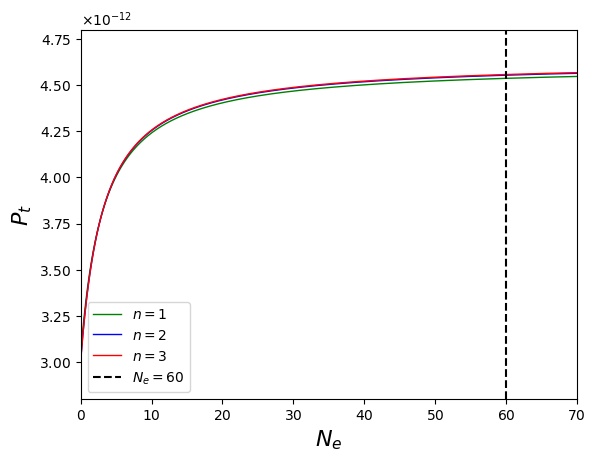

In [90]:
plt.plot(Ne1, Pt1, 'g', lw=1, label=r'$n=1$')
plt.plot(Ne2, Pt2, 'b', lw=1, label=r'$n=2$')
plt.plot(Ne3, Pt3, 'r', lw=1, label=r'$n=3$')
plt.axvline(Nk, color='black', linestyle='--', label = f'$N_e={Nk}$')
# plt.yscale('log')
plt.xlim(0,70)
plt.ylim(2.8e-12,4.8e-12)
plt.xlabel(r'$N_e$', fontsize=16)
plt.ylabel(r'$P_t$', fontsize=16)
plt.legend()
plt.savefig("./Figures/Pt_compiled vs Ne.pdf", dpi=300, bbox_inches='tight')
plt.show()

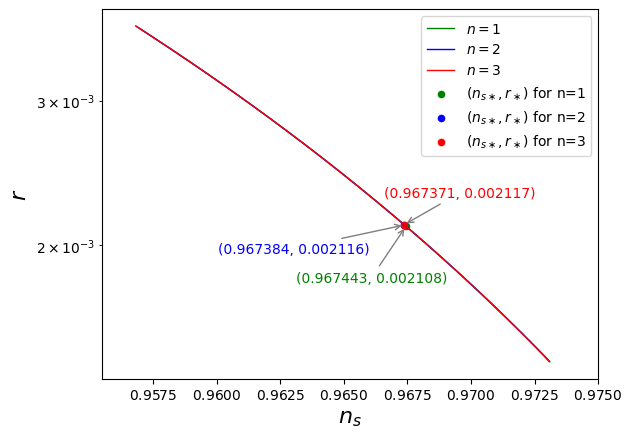

In [94]:
bound = np.arange(i(N,Nt-(Nk+13)),i(N,Nt-(Nk-15))+1,1)

plt.plot(ns1[bound], r1[bound], 'g', lw=1, label=r'$n=1$')
plt.plot(ns2[bound], r2[bound], 'b', lw=1, label=r'$n=2$')
plt.plot(ns3[bound], r3[bound], 'r', lw=1, label=r'$n=3$')
plt.yscale('log')
px=ns1[i(N1, Nt-Nk)] 
py=r1[i(N1, Nt-Nk)]
plt.annotate(f'({px:.6f}, {py:.6f})', 
             (px, py), 
             textcoords="offset points", 
             xytext=(-25, -40),   # offset from point
             ha='center', 
             fontsize=10, 
             color='g',
             arrowprops=dict(arrowstyle='->', color='gray', lw=1))
plt.scatter(px, py, color='g', s=20, label=fr'$(n_{{s\ast}}, r_\ast)$ for n=1')

px=ns2[i(N2, Nt-Nk)] 
py=r2[i(N2, Nt-Nk)]
plt.annotate(f'({px:.6f}, {py:.6f})', 
             (px, py), 
             textcoords="offset points", 
             xytext=(-80, -20),   # offset from point
             ha='center', 
             fontsize=10, 
             color='b',
             arrowprops=dict(arrowstyle='->', color='gray', lw=1))
plt.scatter(px, py, color='b', s=20, label=fr'$(n_{{s\ast}}, r_\ast)$ for n=2')

px=ns3[i(N3, Nt-Nk)] 
py=r3[i(N3, Nt-Nk)]
plt.annotate(f'({px:.6f}, {py:.6f})', 
             (px, py), 
             textcoords="offset points", 
             xytext=(40, 20),   # offset from point
             ha='center', 
             fontsize=10, 
             color='r',
             arrowprops=dict(arrowstyle='->', color='gray', lw=1))
plt.scatter(px, py, color='r', s=20, label=fr'$(n_{{s\ast}}, r_\ast)$ for n=3')
# plt.axvline(ns[i(N, Nt-Nk)], color='black', linestyle='--', label = f'$n_s(N_e={Nk})$ ={ns[i(N, Nt-Nk)]}') 
# plt.ylim(0, 1.5)
# plt.ylim(bottom = 0)
plt.xlabel(r'$n_s$', fontsize=16)
plt.ylabel(r'$r$', fontsize=16)
plt.xlim(0.9555, 0.975)
plt.legend()
plt.savefig("./Figures/r_compiled vs ns.pdf", dpi=300, bbox_inches='tight')
plt.show()

# First-order perturbations
As discussed elaborately in our [article](https://arxiv.org/abs/2212.00529), The  Fourier modes $v_k$ and $h_k$ (for scalar modes and tensor modes respectively) of the field satisfy the  Mukhanov-Sasaki equations which, in terms of cosmic time $t$, take the form:
$$ \ddot{v_k} +  H \dot{v_k} + \left[ \frac{k^2}{a^2} - \frac{1}{a^2} \frac{z''}{z} \right] v_k = 0 $$
$$ \ddot{h_k} +  H \dot{h_k} + \left[ \frac{k^2}{a^2} - \frac{1}{a^2} \frac{a''}{a} \right] h_k = 0 $$
As is evident from the expressions, the Fourier modes are characterised by the wavenumber $k$. In order to compute the evolution of a particular mode, we must know the time at which it becomes super-Hubble.

## Horizon exit of modes
Quantum fluctuations during inflation are generated in the sub-Hubble regime and as the Hubble radius shrinks, the comoving wavelengths of different modes become equal to the Hubble radius (i.e., $k=aH$). This is known as Hubble exit. We can determine the Hubble exit time for different modes by plotting the following:

In [22]:
S = 5e-5
Ai = 1e-3

z = H/S
A = Ai*np.exp(N)

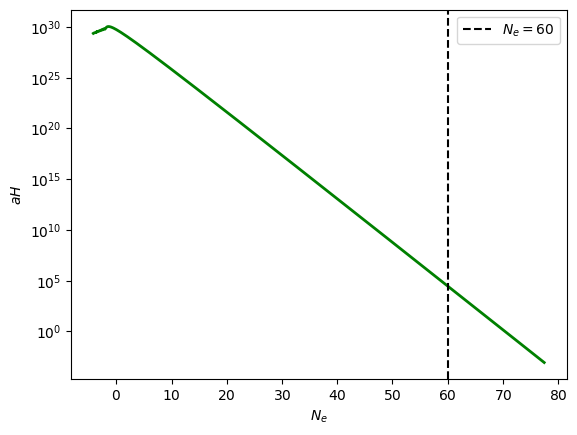

In [52]:
aH = A*z # rate of change of scale factor

plt.plot(Ne, aH, 'g', lw=2)
plt.xlabel(r'$N_e$')
plt.ylabel(r'$aH$')
plt.axvline(Nk, color='black', linestyle='--', label = f'$N_e={Nk}$')
plt.yscale('log')
plt.legend()
plt.show()

For example, the mode that leaves the horizon at about 60 e-folds before the end of inflation corresponds to a wavenumber of about $10^5$. We call this the CMB pivot scale and fix its value as $0.05\,\mathrm{MPc}^{-1}$ from observations. We can then determine the wavelengths of all the modes corresponding to their horizon exit.

We can read exact values by defining an index function that returns the location of a certain value of a quantity in its evolution array and then use it to determine the wavelength of any mode by specifying its horizon exit in terms of number of e-folds before the end of inflation.

In [53]:
Nk = 60
k_star = aH[i(N, Nt-Nk)]
print("Pivot scale, k_star:", k_star)

Pivot scale, k_star: 29003.150587011645


## System of equations including fluctuations

We can write the Mukhanov-Sasaki equations in terms of our dimensionless variables as:
$$
v_{k,T} = \frac{{\rm d}v_k}{{\rm d}T}
$$
$$
\frac{{\rm d}v_{k,T}}{{\rm d}T} = - z \, v_{k,T} - \left[ \frac{k^2}{A^2} - \frac{5}{2} \, y^2 + 2 \, \frac{y}{z} \left(3 \, z \, y + \frac{v_0}{S^{2}} \, f_{,x} \right) - 2 \, z^2 - \frac{1}{2} \, \frac{y^4}{z^2} + \frac{v_0}{S^2} \, f_{,xx} \right]v_k
$$
$$
h_{k,T} = \frac{{\rm d}h_k}{{\rm d}T}
$$
$$
\frac{{\rm d}h_{k,T}}{{\rm d}T} = -  z \, h_{k,T} - \left(  \frac{k^2}{A^2} + \frac{1}{2} \, y^2 - 2 \, z^2  \right) \, h_k
$$

### Initial conditions
In order to simulate the evolution of a perturbation mode around its horizon exit, we enter its initial conditions when it was considerably sub-Hubble. This corresponds to the Bunch-Davies vacuum:
$$v_k = \frac{1}{\sqrt{2k}}e^{-ik\tau}$$
This is safely satisfied for every mode till about 5 e-folds before its horizon exit. Hence, we enter the values of the background quantities at this time as their initial conditions.

In [54]:
ind = i(N, Nt-(Nk+5))
k_star = aH[i(N, Nt-Nk)]

xqi = x[ind]
yqi = y[ind]
zqi = np.sqrt(yqi**2/6 + (V0*f(xqi)/(3*S**2)))
Aqi = 1e-3 * np.exp(Nt - (Nk+5))

# Initial conditions for the fluctuations (in Mukhanov-Sasaki variables) are given by the Bunch-Davies vacuum
vi = (1/np.sqrt(2*k_star)) # real part of the field that describes scalar fluctuations
ui = 0 # imaginary part of the field that describes scalar fluctuations
v_Ti = 0
u_Ti = -k_star*(1/np.sqrt(2*k_star))/Aqi
# Same applies for tensor fluctuations too
hi = (1/np.sqrt(2*k_star)) # real part of the field that describes tensor fluctuations
gi = 0 # imaginary part of the field that describes tensor fluctuations
h_Ti = 0
g_Ti = -k_star*(1/np.sqrt(2*k_star))/Aqi

### Redefining the system to be solved
We can now define our system of equations including the equations of motion for perturbations.

In [55]:
def sys(var, T):
    [x, y, z, A, v, v_T, u, u_T, h, h_T, g, g_T] = var

    #background
    dxdT = y
    dydT = -3*z*y - V0*dfdx(x)/S**2
    dzdT = -0.5*y**2
    dAdT = A*z

    # scalar fluctuations
    dvdT = v_T
    dv_TdT = -z*v_T + v*(2.5*y**2 + 2*y*(-3*z*y - V0*dfdx(x)/S**2 )/z + 2*z**2 + 0.5*y**4/z**2 - V0*d2fdx2(x)/S**2 - k_star**2/A**2)
    dudT = u_T
    du_TdT = -z*u_T + u*(2.5*y**2 + 2*y*(-3*z*y - V0*dfdx(x)/S**2 )/z + 2*z**2 + 0.5*y**4/z**2 - V0*d2fdx2(x)/S**2 - k_star**2/A**2)

    # tensor fluctuations
    dhdT = h_T
    dh_TdT = -z*h_T - h*(k_star**2/A**2 - 2*z**2 + 0.5*y**2)
    dgdT = g_T
    dg_TdT = -z*g_T - g*(k_star**2/A**2 - 2*z**2 + 0.5*y**2)

    return [dxdT, dydT, dzdT, dAdT, dvdT, dv_TdT, dudT, du_TdT, dhdT, dh_TdT, dgdT, dg_TdT]

## Invoking the solver
We simulate the evolution of the specified mode for just enough time such that it freezes after becoming super-Hubble. This is satisfied about 5 e-folds after horizon-exit for most modes.

In [56]:
# the period of time over which the system is integrated
T = np.linspace(0, 1000, 10000)

sol = odeint(sys, [xqi,yqi,zqi,Aqi,vi,v_Ti,ui,u_Ti,hi,h_Ti,gi,g_Ti], T, rtol=3e-7, atol=2e-35, mxstep=900000000)
xq, yq, zq, Aq, v, v_T, u, u_T, h, h_T, g, g_T = np.transpose(sol)

## Derived quantities
It is useful to define a quantity ($aH/k$) that indicates whether the specified mode is in the sub-Hubble or super-Hubble regime, along with all the derived quantities as defined for background calculations.

In [57]:
aHk = (Aq*zq)/k_star
meff = 2.5*yq**2 + 2*yq*(-3*zq*yq - V0*dfdx(xq)/S**2 )/zq + 2*zq**2 + 0.5*yq**4/zq**2 - V0*d2fdx2(xq)/S**2

# slow-roll parameters
epsH = -(-zq**2 + ((V0*f(xq)/S**2 - yq**2))/3)/zq**2
etaH = -(-3*zq*yq - V0*dfdx(xq)/S**2)/(yq*zq)

# observable quantities (under slow-roll apparoximation)
Nq = np.log(Aq/Aqi) 
Nqe = Nt - Nq
ns = 1 + 2*etaH - 4*epsH
r = 16*epsH
Pqs = (S*zq)**2 / (8 * np.pi**2 * epsH)
Pqt = 4*(S*zq)**2 / (np.pi**2)

# values of power spectra
R2 = (v**2 + u**2)/(2*epsH*(Aq/S)**2) # scalar fluctuations
P_S = (k_star**3 * R2)/(2*np.pi**2)
h2 = (h**2 + g**2)/((Aq/S)**2) # tensor fluctuations
P_T = 4*(k_star**3 * h2)/(np.pi**2)

In [ ]:
# horizon crossing index
# idx_cross = np.argmin(np.abs(aH/k - 1.0))
# idx_final = -1

# print("aH/k at start, cross, end:", aH[0]/k, aH[idx_cross]/k, aH[-1]/k)
# print("eps at cross:", epsH[idx_cross])
# print("H (z) at cross:", z[idx_cross])
# print("Ps_sr (cross) = ", (S*z[idx_cross])**2 / (8*np.pi**2 * epsH[idx_cross]))
# print("P_S (numerical, final) = ", P_S[idx_final])
# print("ratio P_S(num final) / Ps_sr(cross) = ", P_S[idx_final] / ((S*z[idx_cross])**2 / (8*np.pi**2 * epsH[idx_cross])))

# # tensor: after you change the denominator to pi^2
# print("Pt_sr (cross) = ", 2*(S*z[idx_cross])**2 / (np.pi**2))
# print("P_T (numerical, final) = ", P_T[idx_final])
# print("ratio P_T(num final) / Pt_sr(cross) = ", P_T[idx_final] / (2*(S*z[idx_cross])**2 / (np.pi**2)))

## Plotting

### We can plot the evolution of the specified mode around its horizon exit as:

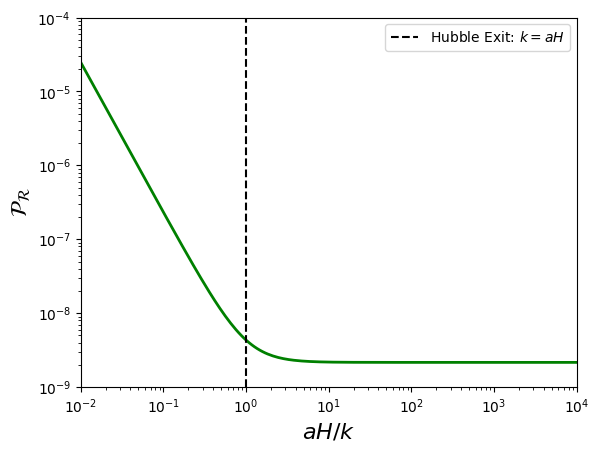

In [58]:
plt.plot(aHk,P_S,'g', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(f'$aH/k$', fontsize=16)
plt.ylabel(fr'$\mathcal{{P}}_\mathcal{{R}}$', fontsize=16)
plt.xlim(1e-2, 1e4)
plt.ylim(1e-9, 1e-4)
plt.axvline(1, color='black', linestyle='--', label = f'Hubble Exit: $k=aH$')
plt.legend()
plt.savefig("./Figures/PR vs aHk.pdf", dpi=300, bbox_inches='tight')
plt.show()

### Plotting the scalar and tensor quantum fluctuations

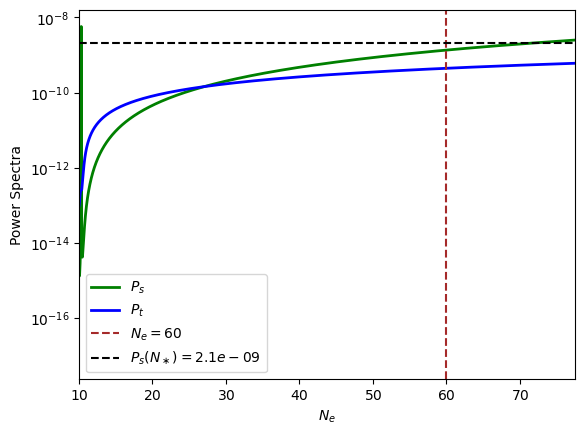

In [59]:
plt.plot(Nqe, Pqs, 'g', lw=2, label=f'$P_s$')
plt.plot(Nqe, Pqt, 'b', lw=2, label=f'$P_t$')
plt.axvline(Nk, color='brown', linestyle='--', label = f'$N_e={Nk}$')
plt.axhline(P_star, color='black', linestyle='--', label = fr'$P_s(N_\ast)={P_star}$')
plt.yscale('log')
plt.xlim(10, max(Ne))
#plt.ylim(1e-14, 1e-8)
plt.xlabel(r'$N_e$')
plt.ylabel(r'Power Spectra')
plt.legend()
plt.show()

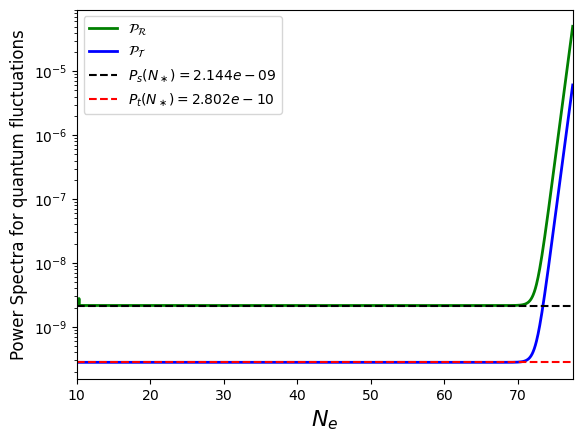

In [60]:
plt.plot(Nqe, P_S,'g', lw=2, label=r'$\mathcal{P}_\mathcal{R}$')
plt.plot(Nqe, P_T, 'b', lw=2, label=r'$\mathcal{P}_\mathcal{T}$')
plt.yscale('log')
plt.xlabel('$N_e$', fontsize=16)
plt.ylabel(r'Power Spectra for quantum fluctuations', fontsize=12)
plt.axhline(Ps[i(N, Nt-Nk)], color='black', linestyle='--', label = fr'$P_s(N_\ast)={Ps[i(N, Nt-Nk)]:.3e}$')
plt.axhline(Pt[i(N, Nt-Nk)], color='red', linestyle='--', label = fr'$P_t(N_\ast)={Pt[i(N, Nt-Nk)]:.3e}$')
plt.xlim(10, max(Ne))
#plt.ylim(1e-14, 1e-8)
# plt.axvline(1, color='black', linestyle='--', label = f'Hubble Exit: $k=aH$')
plt.legend()
plt.show()

In [61]:
Nk_list = np.linspace(0,71,25)
print(Nk_list)

[ 0.          2.95833333  5.91666667  8.875      11.83333333 14.79166667
 17.75       20.70833333 23.66666667 26.625      29.58333333 32.54166667
 35.5        38.45833333 41.41666667 44.375      47.33333333 50.29166667
 53.25       56.20833333 59.16666667 62.125      65.08333333 68.04166667
 71.        ]


In [62]:
Pr_list = []
Pt_list = []

for Nk in Nk_list:
    ind = i(N, Nt-(Nk+5))
    k_star = aH[i(N, Nt-Nk)]
    
    xqi = x[ind]
    yqi = y[ind]
    zqi = np.sqrt(yqi**2/6 + (V0*f(xqi)/(3*S**2)))
    Aqi = 1e-3 * np.exp(Nt - (Nk+5))

    # Initial conditions for the fluctuations (in Mukhanov-Sasaki variables) are given by the Bunch-Davies vacuum
    vi = (1/np.sqrt(2*k_star)) # real part of the field that describes scalar fluctuations
    ui = 0 # imaginary part of the field that describes scalar fluctuations
    v_Ti = 0
    u_Ti = -k_star*(1/np.sqrt(2*k_star))/Aqi
    # Same applies for tensor fluctuations too
    hi = (1/np.sqrt(2*k_star)) # real part of the field that describes tensor fluctuations
    gi = 0 # imaginary part of the field that describes tensor fluctuations
    h_Ti = 0
    g_Ti = -k_star*(1/np.sqrt(2*k_star))/Aqi
    

    sol = odeint(sys, [xqi,yqi,zqi,Aqi,vi,v_Ti,ui,u_Ti,hi,h_Ti,gi,g_Ti], T, rtol=3e-7, atol=2e-35, mxstep=900000000)
    xq, yq, zq, Aq, v, v_T, u, u_T, h, h_T, g, g_T = np.transpose(sol)
    
    aHk = (Aq*zq)/k_star
    meff = 2.5*yq**2 + 2*yq*(-3*zq*yq - V0*dfdx(xq)/S**2 )/zq + 2*zq**2 + 0.5*yq**4/zq**2 - V0*d2fdx2(xq)/S**2

    # slow-roll parameters
    epsH = -(-zq**2 + ((V0*f(xq)/S**2 - yq**2))/3)/zq**2
    etaH = -(-3*zq*yq - V0*dfdx(xq)/S**2)/(yq*zq)
    
    # observable quantities (under slow-roll apparoximation)
    Nq = np.log(Aq/Aqi) 
    Nqe = Nt - Nq
    # Ps = (S*zq)**2 / (8 * np.pi**2 * epsH)
    # Pt = 4*(S*zq)**2 / (np.pi**2)
    
    # values of power spectra
    R2 = (v**2 + u**2)/(2*epsH*(Aq/S)**2) # scalar fluctuations
    P_S = (k_star**3 * R2)/(2*np.pi**2)
    h2 = (h**2 + g**2)/((Aq/S)**2) # tensor fluctuations
    P_T = 4*(k_star**3 * h2)/(np.pi**2)
    
    Pr_list.append(P_S[i(Nq, Nt-20)])
    Pt_list.append(P_T[i(Nq, Nt-20)])

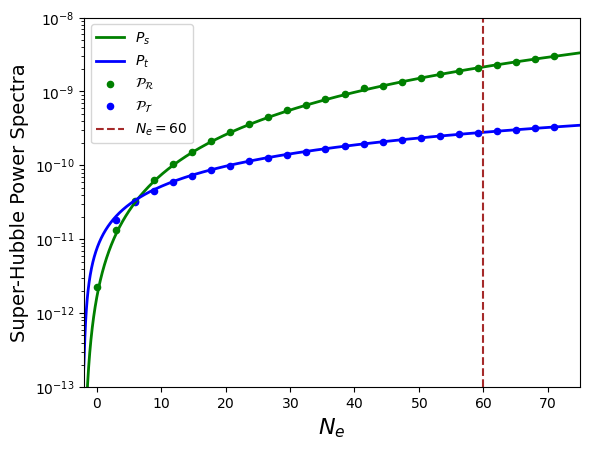

In [64]:
plt.plot(Ne, Ps, 'g', lw=2, label=f'$P_s$')
plt.plot(Ne, Pt, 'b', lw=2, label=f'$P_t$')
plt.scatter(Nk_list, Pr_list, c='g', s=20, label=r'$\mathcal{P}_\mathcal{R}$')
plt.scatter(Nk_list, Pt_list, c='b', s=20, label=r'$\mathcal{P}_\mathcal{T}$')
plt.axvline(60, color='brown', linestyle='--', label=r'$N_e=60$')
# plt.axhline(P_star, color='black', linestyle='--')
plt.yscale('log')
plt.xlim(-2, 75)
plt.ylim(1e-13, 1e-8)
plt.xlabel(r'$N_e$', fontsize=16)
plt.ylabel(r'Super-Hubble Power Spectra', fontsize=14)
plt.legend()
plt.savefig("./Figures/All power spectra vs Ne.pdf", dpi=300, bbox_inches='tight')
plt.show()

### Compiled function

In [ ]:
importlib.reload(inflation)

In [17]:
def i(f, val):
    return np.max(np.where(f<=val))

In [24]:
Nk = 60
k_star = aH[i(N, Nt-Nk)]

In [25]:
def f(x, params):
    n, lamda = params
    p = 2*n
    return np.tanh(lamda*x)**p

def dfdx(x, params):
    n, lamda = params
    p = 2*n
    return p*lamda*(1-np.tanh(lamda*x)**2)*np.tanh(lamda*x)**(p-1)

def d2fdx2(x, params):
    n, lamda = params
    p = 2*n
    return p*(lamda**2)*(1-np.tanh(lamda*x)**2)*np.tanh(lamda*x)**(p-2)*(p-1-(p+1)*np.tanh(lamda*x)**2)

In [26]:
model_funcs = [f, dfdx, d2fdx2]

In [27]:
var = [phi, phi_t, H, N, V0]

In [28]:
phiq, phqi_t, Hq, Nq, Nqe, epsq, etaq, P_S, P_T, meff = inflation.mukhanov_sasaki([1, 0.5], var, model_funcs)

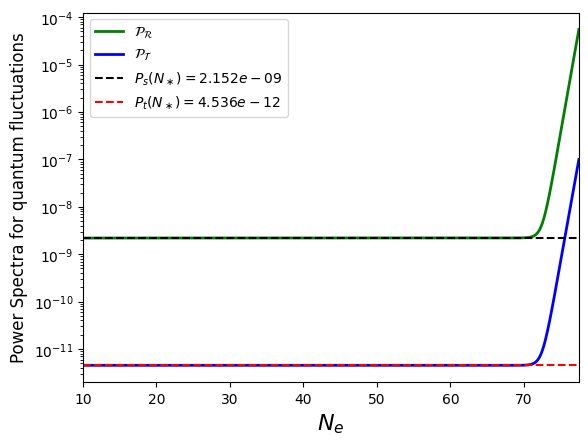

In [29]:
plt.plot(Nqe, P_S,'g', lw=2, label=r'$\mathcal{P}_\mathcal{R}$')
plt.plot(Nqe, P_T, 'b', lw=2, label=r'$\mathcal{P}_\mathcal{T}$')
plt.yscale('log')
plt.xlabel('$N_e$', fontsize=16)
plt.ylabel(r'Power Spectra for quantum fluctuations', fontsize=12)
plt.axhline(Ps[i(N, Nt-Nk)], color='black', linestyle='--', label = fr'$P_s(N_\ast)={Ps[i(N, Nt-Nk)]:.3e}$')
plt.axhline(Pt[i(N, Nt-Nk)], color='red', linestyle='--', label = fr'$P_t(N_\ast)={Pt[i(N, Nt-Nk)]:.3e}$')
plt.xlim(10, max(Ne))
#plt.ylim(1e-14, 1e-8)
# plt.axvline(1, color='black', linestyle='--', label = f'Hubble Exit: $k=aH$')
plt.legend()
plt.show()

### Comparison between different n valued potentials

In [30]:
var1 = [phi1, phi_t1, H1, N1, V01]
var2 = [phi2, phi_t2, H2, N2, V02]
var3 = [phi3, phi_t3, H3, N3, V03]

In [31]:
phiq1, phqi_t1, Hq1, Nq1, Nqe1, epsq1, etaq1, P_S1, P_T1, meff1 = inflation.mukhanov_sasaki([1, 0.5], var1, model_funcs)
phiq2, phqi_t2, Hq2, Nq2, Nqe2, epsq2, etaq2, P_S2, P_T2, meff2 = inflation.mukhanov_sasaki([2, 0.5], var2, model_funcs)
phiq3, phqi_t3, Hq3, Nq3, Nqe3, epsq3, etaq3, P_S3, P_T3, meff3 = inflation.mukhanov_sasaki([3, 0.5], var3, model_funcs)

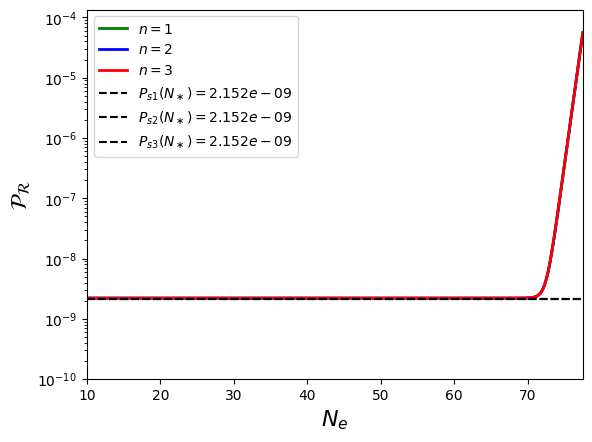

In [32]:
plt.plot(Nqe1, P_S1,'g', lw=2, label=r'$n=1$')
plt.plot(Nqe2, P_S2,'b', lw=2, label=r'$n=2$')
plt.plot(Nqe3, P_S3,'r', lw=2, label=r'$n=3$')
plt.yscale('log')
plt.xlabel('$N_e$', fontsize=16)
plt.ylabel(r'$\mathcal{P}_\mathcal{R}$', fontsize=16)
plt.axhline(Ps1[i(N1, Nt-Nk)], color='black', linestyle='--', label = fr'$P_{{s1}}(N_\ast)={Ps1[i(N1, Nt-Nk)]:.3e}$')
plt.axhline(Ps2[i(N2, Nt-Nk)], color='black', linestyle='--', label = fr'$P_{{s2}}(N_\ast)={Ps2[i(N2, Nt-Nk)]:.3e}$')
plt.axhline(Ps3[i(N3, Nt-Nk)], color='black', linestyle='--', label = fr'$P_{{s3}}(N_\ast)={Ps3[i(N3, Nt-Nk)]:.3e}$')
plt.xlim(10, np.max([Ne1, Ne2, Ne3]))
plt.ylim(bottom=1e-10)
plt.legend()
plt.show()

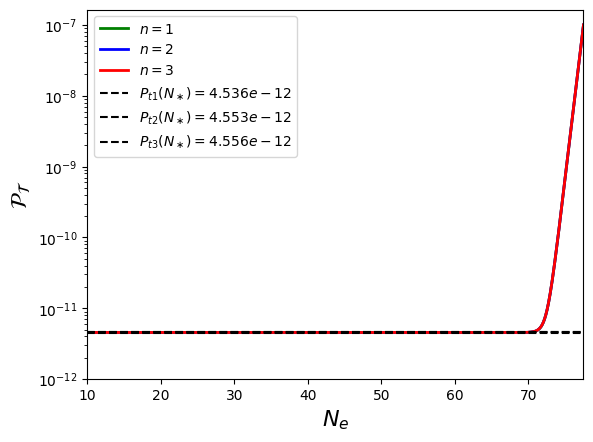

In [33]:
plt.plot(Nqe1, P_T1,'g', lw=2, label=r'$n=1$')
plt.plot(Nqe2, P_T2,'b', lw=2, label=r'$n=2$')
plt.plot(Nqe3, P_T3,'r', lw=2, label=r'$n=3$')
plt.yscale('log')
plt.xlabel('$N_e$', fontsize=16)
plt.ylabel(r'$\mathcal{P}_\mathcal{T}$', fontsize=16)
plt.axhline(Pt1[i(N1, Nt-Nk)], color='black', linestyle='--', label = fr'$P_{{t1}}(N_\ast)={Pt1[i(N1, Nt-Nk)]:.3e}$')
plt.axhline(Pt2[i(N2, Nt-Nk)], color='black', linestyle='--', label = fr'$P_{{t2}}(N_\ast)={Pt2[i(N2, Nt-Nk)]:.3e}$')
plt.axhline(Pt3[i(N3, Nt-Nk)], color='black', linestyle='--', label = fr'$P_{{t3}}(N_\ast)={Pt3[i(N3, Nt-Nk)]:.3e}$')
plt.xlim(10, np.max([Ne1, Ne2, Ne3]))
plt.ylim(bottom=1e-12)
plt.legend()
plt.show()